# Exercise 1.  Data Organization and Signal Averaging

### This exercise introduces the organization of EEG data for analysis. There were many preprocessing steps prior to this point, specifically
*   Segmentation of each trial of the experiment
*   Removal of trials with excessive artifacts 
*   Signal processing to remove eye blinks and eye movements from the EEG 
*   Organization of EEG, trial labels, and behavioral data into a structure.  


## Target Detection Experiment 

### These data were extracted from the ERP CORE (https://osf.io/thsqg/wiki/home/).  

### These are data from the experiment, **Active Visual Oddball P3**

### Some details of the experiment - 
*   The stimulus consists of the letters A, B, C, D, E
*   In any block, one of the 5 letters was designated the "target" with a response with one hand, while the others were designated "standards" with response with the other hand. 
*   The probability of any letter appearing is 0.2.  
*   The probability of a target appearing is 0.2 

#### Load modules that we need 

In [77]:
import numpy as np 
from matplotlib import pyplot as plt
from hdf5storage import loadmat, savemat 


## Data Files 

### I provided example data files for this tutorial in a hdf5 format file.  Matlab users will know this as a .mat file.  
### There are native file formats in python called pickle, which are super convenient, but are not appropriate for sharing as they are insecure.    

In [78]:
data = loadmat('data/2_P3.mat')

### Loadmat will will load a datafile into a dictionary.  A **dictionary** is a data structure in python that allows us to keep related data (for example from one data collection) together.  

### To understand a dictionary contents, the best thing to do is to print out the **keys**.  

In [79]:
data.keys()

dict_keys(['blocktarget', 'channelnames', 'eeg', 'eeg_time', 'goodtrials', 'nchannels', 'ntrials', 'response', 'responsetime', 'samplingrate', 'stimulus', 'target'])

### I habitually copy out the elements of a dictionary into simple variables, to make my life easy.  This is not required, and may use up memory. 

### To track everything, I use the key names as my variable names

In [80]:
blocktarget = data['blocktarget']
channelnames = data['channelnames']
eeg = data['eeg']
eeg_time = data['eeg_time']
goodtrials = data['goodtrials']
nchannels = data['nchannels']
ntrials = data['ntrials']
response = data['response']
responsetime = data['responsetime']
samplingrate = data['samplingrate']
stimulus = data['stimulus']
target = data['target']
print(channelnames)

['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'P3', 'P7', 'PO7', 'PO3', 'O1', 'Oz', 'Pz', 'CPz', 'FP2', 'Fz', 'F4', 'F8', 'FC4', 'FCz', 'Cz', 'C4', 'C6', 'P4', 'P8', 'PO8', 'PO4', 'O2']


## README 

### The information about the datafiles in an experiment is normally placed in a README file. 
### For convenience I am going to place that information here instead.

###  This data was obtained from the archive ERP CORE and reorganized for this class. 
###  Each file contains the data of one participant, indicated in the filename. 
###  The variables contained here are 

*   `ntrials` - number of trials in the experiment 
*   `nchannels` - number of EEG channels 
*   `samplingrate` - number of samples of EEG in per second
*   `eeg` - eegdata of the experiment.  of dimensions, ntrials x nchannels x ntimepoints.  The EEG is provided in units of volts. 
*   `eeg_time` - the time relative to *stimulus onset* in each EEG observation.
*   `channelnames` - the name of the EEG channels indicating where it is located.    
*   `stimulus` - the stimulus presented on each good trial, 1 = A, 2 = B, 3 = C, 4 = D, 5 = E 
*   `target` - the target stimulus on each good trial 1 = A, 2 = B, 3 = C, 4 = D, 5 = E
*   `blocktarget` - indicates which trial had the target on each block, 1 if a target 0 if not a target. 
*   `response` - variable indicating the response accuracy 1 = correct, -1 = incorrect, 0 = no response,
*   `responsetime` - time after stimulus onset when the subject provided a response. 
*   `goodtrials` - vector with value 1 if the trial had a response, 0 if no response or multiple responses.   


### We can and should take a look at these variables manually before proceding 

### Stimulus and Target 

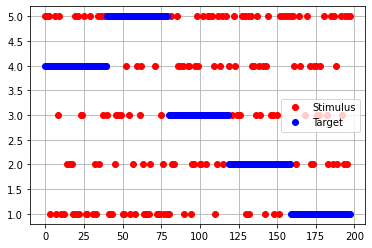

In [81]:
plt.plot(stimulus,'ro')
plt.plot(target,'bo')
plt.grid()
plt.legend(('Stimulus','Target'))
plt.show()

### Response 

In [82]:
[values, instances] = np.unique(response,return_counts = True)
print('Values are: ', values)
print('Occuring: ', instances)

Values are:  [1]
Occuring:  [198]


### Response Time 

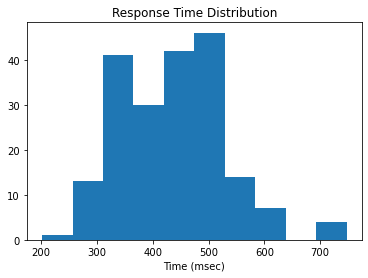

In [83]:
plt.hist(responsetime)
plt.title('Response Time Distribution')
plt.xlabel('Time (msec)')
plt.show()

In [84]:
test = (goodtrials == 1)

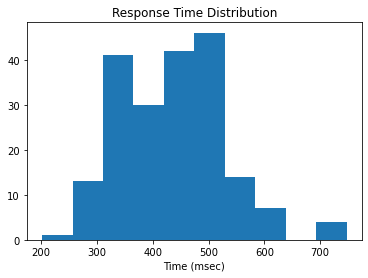

In [85]:
plt.hist(responsetime[goodtrials == 1])
plt.title('Response Time Distribution')
plt.xlabel('Time (msec)')
plt.show()

### Plot some EEG 

### The eeg variable is 3 dimensional.  The first dimension is the trial, the second dimension is the channel, 3rd dimension is time.  

#### I am going to plot the first trial, channel 20, 

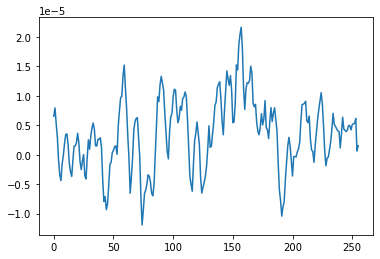

In [86]:
plt.plot(eeg[0,20,:])
plt.show()

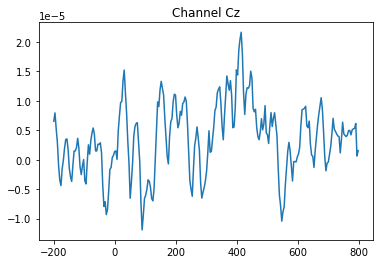

In [87]:
plt.plot(eeg_time,eeg[0,20,:])
plt.title('Channel '+channelnames[20])
plt.show()

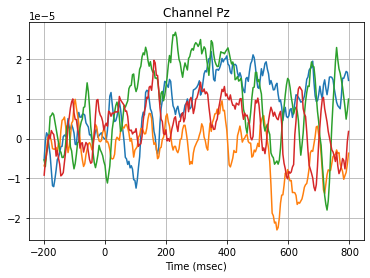

In [88]:
plt.plot(eeg_time,np.transpose(eeg[0:4,12,:]))
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.grid()
plt.show()

## EVENT RELATED POTENTIALS 
### Its just a **mean**

In [89]:
erp = np.mean(eeg,axis =0)


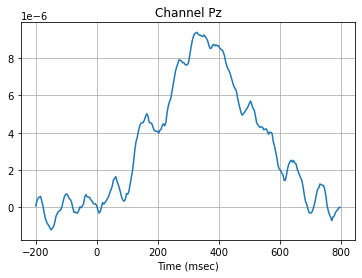

In [90]:
plt.plot(eeg_time,erp[12,:])
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.grid()
plt.show()

### I need to take care of locating good trials

In [91]:
erp = np.mean(eeg[goodtrials == 1,:,:],axis =0)

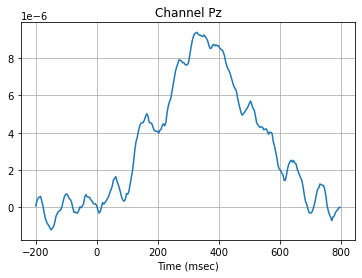

In [92]:
plt.plot(eeg_time,erp[12,:])
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.grid()
plt.show()

## TASK CONTRAST

### In analysis neural data there is usually a task contrast, or patient/control contrast I am really interested in.  

### So averaging all the data together doesnt really inform me of everything. 

### In this task, the critical thing we are looking for is the difference between a target and a standard. 

### A target trial would correspond to when the stimulus and the target objective were the same. 

### So I need to interest the two conditions in a compound logical statement.  

In [93]:
erp_target = np.mean(eeg[(goodtrials == 1)&(stimulus==target),:,:],axis =0)

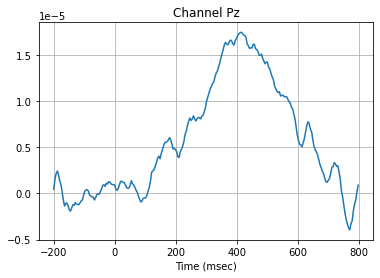

In [94]:
plt.plot(eeg_time,erp_target[12,:])
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.grid()
plt.show()

In [95]:
erp_target = np.mean(eeg[(goodtrials == 1)&(blocktarget > 0),:,:],axis =0)
erp_standard = np.mean(eeg[(goodtrials == 1)&(blocktarget == 0),:,:],axis =0)

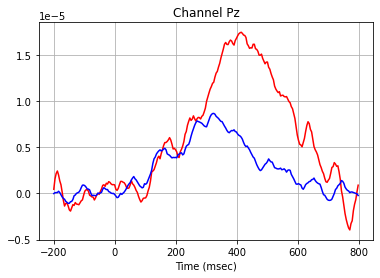

In [96]:
plt.plot(eeg_time,erp_target[12,:],'r')
plt.plot(eeg_time,erp_standard[12,:],'b')
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.grid()
plt.show()

## Problem 1:

#### Make a new estimate of ERP_standard with the same number of trials included in the average as ERP_target. For your convenience I have made a variable blocktarget which contains a value of 1,2,3,4,5 for each time the stimulus was the target and 0 otherwise. 

#### One way to do this is to use the trial just before the target as your "standard" trials.  The idea is that all other things are as equal as possible when you look at that response. 



1.  find the standard trials 

In [97]:
target_indices = np.nonzero (blocktarget)
standard_indices = np.subtract (target_indices, 1)
blocktarget_indices = np.arange (198)
ERP_standard = np.mean(eeg[(goodtrials == 1)& np.isin(blocktarget_indices,standard_indices),:,:], axis = 0)



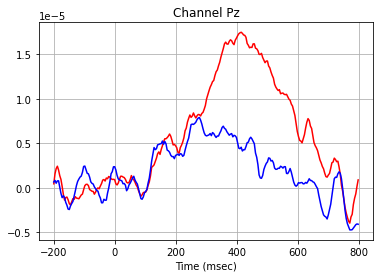

In [108]:
erp_target = np.mean(eeg[(goodtrials == 1)&(blocktarget > 0),:,:],axis =0)
plt.plot(eeg_time,erp_target[12,:],'r')
plt.plot(eeg_time,ERP_standard[12,:],'b')
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.grid()
plt.show()

## Problem #2: 

#### Create 5 separate ERP averages for each letter using only the standards (dont include the targets).  Also make an average for just all the targets together irrespective of letter identity as in problem 1. 

#### Investigate the channels O1, O2, PO7, PO8 to examine if the deflection of the signal around 170 ms shows any difference for different letter identities (5 cases) or for the target (1 case). 

#### Make a plot of each channel with all 6 waveforms (4 plots in total each with 6 waveforms).  

blocktarget =1

In [98]:
blockttarget_indices = np.arange (198)
indices1 = np.where (blocktarget == 1)
standard1 = np.subtract (indices1, 1)
ERP_standard1 = np.mean(eeg[(goodtrials == 1)& np.isin(blocktarget_indices,standard1),:,:], axis = 0)


blocktarget = 2

In [99]:
blockttarget_indices = np.arange (198)
indices2 = np.where (blocktarget == 2)
standard2 = np.subtract (indices2, 1)
ERP_standard2 = np.mean(eeg[(goodtrials == 1)& np.isin(blocktarget_indices,standard2),:,:], axis = 0)

blocktarget = 3

In [100]:
blockttarget_indices = np.arange (198)
indices3 = np.where (blocktarget == 3)
standard3 = np.subtract (indices3, 1)
ERP_standard3 = np.mean(eeg[(goodtrials == 1)& np.isin(blocktarget_indices,standard3),:,:], axis = 0)

blocktarget = 4

In [101]:
blockttarget_indices = np.arange (198)
indices4 = np.where (blocktarget == 3)
standard4 = np.subtract (indices4, 1)
ERP_standard4 = np.mean(eeg[(goodtrials == 1)& np.isin(blocktarget_indices,standard4),:,:], axis = 0)

blocktarget = 5

In [102]:
blockttarget_indices = np.arange (198)
indices5 = np.where (blocktarget == 5)
standard5 = np.subtract (indices5, 1)
ERP_standard5 = np.mean(eeg[(goodtrials == 1)& np.isin(blocktarget_indices,standard5),:,:], axis = 0)

plot PO7

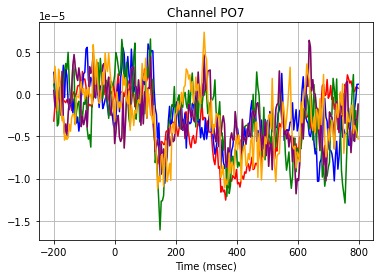

In [103]:
erp_target = np.mean(eeg[(goodtrials == 1)&(blocktarget > 0),:,:],axis =0)
plt.plot(eeg_time,erp_target[8,:],'r')
plt.plot(eeg_time,ERP_standard1[8,:], 'b')
plt.plot(eeg_time,ERP_standard2[8,:],'g')
plt.plot(eeg_time,ERP_standard3[8,:],'y')
plt.plot(eeg_time,ERP_standard4[8,:],'purple')
plt.plot(eeg_time,ERP_standard5[8,:],'orange')
plt.title('Channel '+channelnames[8])
plt.xlabel('Time (msec)')
plt.grid()
plt.show()

plot O1

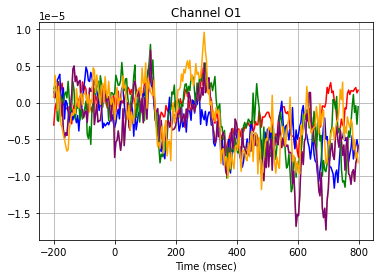

In [104]:
erp_target = np.mean(eeg[(goodtrials == 1)&(blocktarget > 0),:,:],axis =0)
plt.plot(eeg_time,erp_target[10,:],'r')
plt.plot(eeg_time,ERP_standard1[10,:], 'b')
plt.plot(eeg_time,ERP_standard2[10,:],'g')
plt.plot(eeg_time,ERP_standard3[10,:],'y')
plt.plot(eeg_time,ERP_standard4[10,:],'purple')
plt.plot(eeg_time,ERP_standard5[10,:],'orange')
plt.title('Channel '+channelnames[10])
plt.xlabel('Time (msec)')
plt.grid()
plt.show()

plot PO8

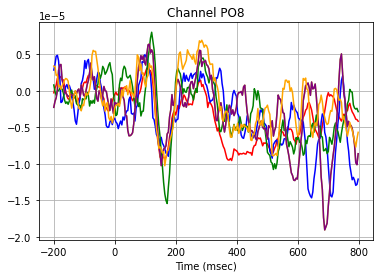

In [105]:
erp_target = np.mean(eeg[(goodtrials == 1)&(blocktarget > 0),:,:],axis =0)
plt.plot(eeg_time,erp_target[25,:],'r')
plt.plot(eeg_time,ERP_standard1[25,:], 'b')
plt.plot(eeg_time,ERP_standard2[25,:],'g')
plt.plot(eeg_time,ERP_standard3[25,:],'y')
plt.plot(eeg_time,ERP_standard4[25,:],'purple')
plt.plot(eeg_time,ERP_standard5[25,:],'orange')
plt.title('Channel '+channelnames[25])
plt.xlabel('Time (msec)')
plt.grid()
plt.show()

plot O2

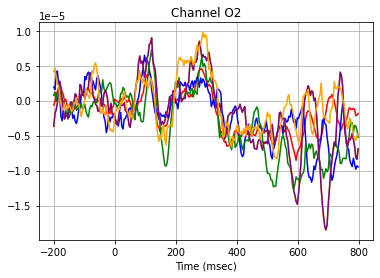

In [107]:
erp_target = np.mean(eeg[(goodtrials == 1)&(blocktarget > 0),:,:],axis =0)
plt.plot(eeg_time,erp_target[27,:],'r')
plt.plot(eeg_time,ERP_standard1[27,:], 'b')
plt.plot(eeg_time,ERP_standard2[27,:],'g')
plt.plot(eeg_time,ERP_standard3[27,:],'y')
plt.plot(eeg_time,ERP_standard4[27,:],'purple')
plt.plot(eeg_time,ERP_standard5[27,:],'orange')
plt.title('Channel '+channelnames[27])
plt.xlabel('Time (msec)')
plt.grid()
plt.show()